In [0]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

In [0]:
#image specs
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

In [0]:
# Size of noise vector used as input to Generator
z_dim = 100

#### Generator

In [0]:
def build_generator(img_shape, z_dim):
  model = Sequential()
  model.add(Dense(128, input_dim=z_dim))        #FC layer
  model.add(LeakyReLU(alpha=0.01))              #LeakyRelu activation
  model.add(Dense(28*28*1, activation='tanh'))  #op layr with tanh activation
  model.add(Reshape(img_shape))                 #Reshape generator op
  return model

#### Discriminator

In [0]:
def build_discriminator(img_shape):
  model = Sequential()
  model.add(Flatten(input_shape=img_shape))   #Flatten ip
  model.add(Dense(128))                       #FC layer
  model.add(LeakyReLU(alpha=0.01))            #LeakyRelu activation
  model.add(Dense(1, activation='sigmoid'))   #op layer for classification
  return model

#### Connect gen and dis

In [0]:
def build_gan(generator, discriminator):
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  return model

In [0]:
#Build and compile Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam())

#Build the generator
generator = build_generator(img_shape, z_dim)

#Keep discriminator parameters constant while generator is training
discriminator.trainable = False

#Build and compile GAN with discriminator fixed
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

#### training

In [0]:
losses = []
accuracies = []
iteration_checkpoint = []

def train(iteration, batch_size, sample_intervals):
  # Load mnist images
  (X_train, _), (_, _) = mnist.load_data()
  #X_train.append(X_test)
  
  # Rescale [0, 255] grayscale pixel values to [-1, 1]
  X_train = X_train / 127.5 - 1.0
  X_train = np.expand_dims(X_train, axis=3)
  
  #Labels for real images
  real = np.ones((batch_size, 1))
  
  #Labels for fake images
  fake = np.zeros((batch_size, 1))
  
  for i in range(iteration):
    # Training the discriminator
    
    # Get random batch of real images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    
    # Generate batch of fakes
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)
    
    # Train discriminator
    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # Training the generator
    
    # Generate fake batch of images
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)
    
    # Train geneerator
    g_loss = gan.train_on_batch(z, real)
    
    if (i + 1)%sample_interval == 0:
      # Save losses and accuracies
      losses.append((d_loss, g_loss))
      accuracies.append(accuracy * 100)
      iteration_checkpoint.append(i + 1)
      
      # Print training progress
      print("%d [D_loss: %f, acc.: %.2f%%] [G_loss: %f]" %(i + 1, d_loss, 100.0 * accuracy, g_loss))
      
      # output sample of generated images
      sample_images(generator)

In [0]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
  # sample random noise
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
  
  # Generate images from random noise
  gen_imgs = generator.predict(z)

  # Rescale image pixel values to [0, 1]
  gen_imgs = 0.5 * gen_imgs + 0.5

  # Set image grid
  fig, axs = plt.subplots(image_grid_rows,
                          image_grid_columns,
                          figsize=(4, 4),
                          sharey=True,
                          sharex=True)
  
  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      # Output a grid of images
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1

#### Train Gan and watch

1000 [D_loss: 0.570958, acc.: 77.34%] [G_loss: 2.973986]
2000 [D_loss: 0.700634, acc.: 71.09%] [G_loss: 2.256469]
3000 [D_loss: 0.533183, acc.: 79.30%] [G_loss: 2.423277]
4000 [D_loss: 0.703041, acc.: 66.41%] [G_loss: 2.200896]
5000 [D_loss: 0.430621, acc.: 79.30%] [G_loss: 2.839876]
6000 [D_loss: 0.860227, acc.: 58.98%] [G_loss: 1.812496]
7000 [D_loss: 0.957841, acc.: 57.03%] [G_loss: 1.842196]
8000 [D_loss: 0.733621, acc.: 63.28%] [G_loss: 1.623145]
9000 [D_loss: 0.868620, acc.: 60.55%] [G_loss: 1.650470]
10000 [D_loss: 0.685625, acc.: 67.58%] [G_loss: 1.825097]
11000 [D_loss: 0.744128, acc.: 59.77%] [G_loss: 1.421889]
12000 [D_loss: 0.779928, acc.: 62.89%] [G_loss: 1.674692]
13000 [D_loss: 1.065707, acc.: 42.97%] [G_loss: 1.562493]
14000 [D_loss: 1.115473, acc.: 37.11%] [G_loss: 1.464863]
15000 [D_loss: 1.242717, acc.: 38.28%] [G_loss: 2.166599]
16000 [D_loss: 1.031031, acc.: 43.75%] [G_loss: 2.086634]
17000 [D_loss: 0.883671, acc.: 50.00%] [G_loss: 2.502348]
18000 [D_loss: 1.356846

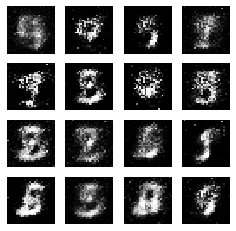

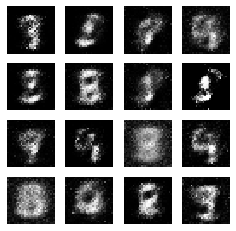

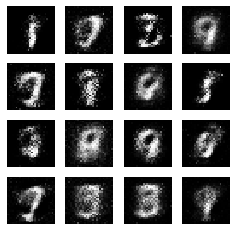

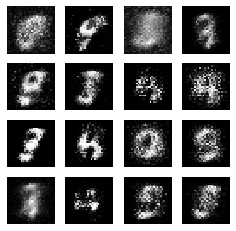

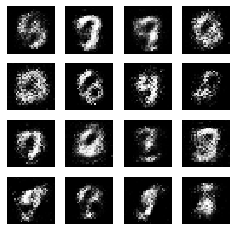

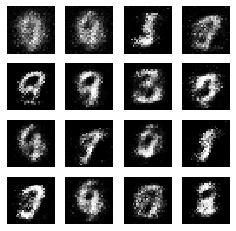

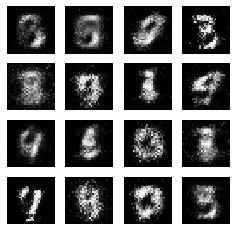

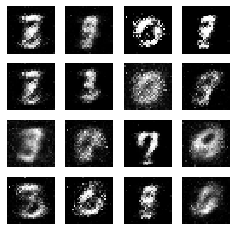

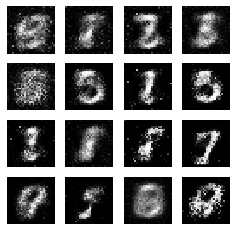

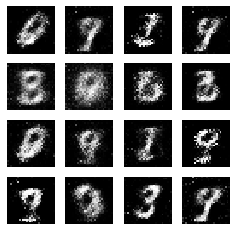

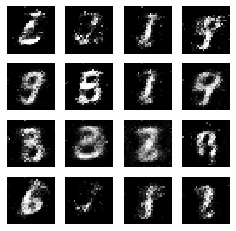

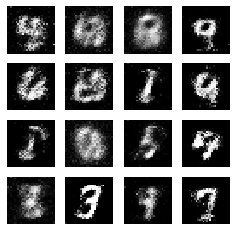

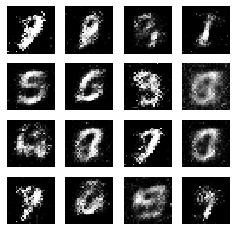

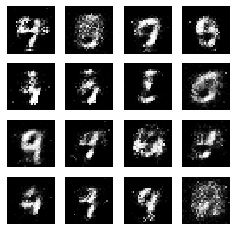

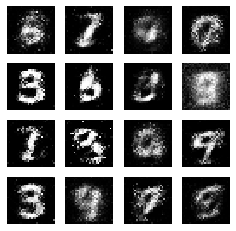

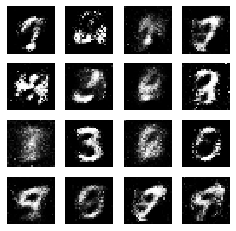

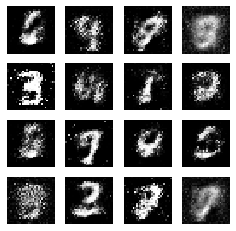

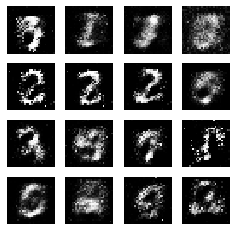

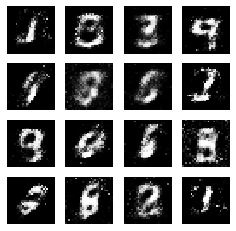

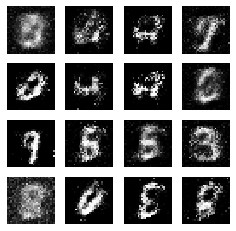

In [35]:
import warnings
warnings.filterwarnings('ignore')
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

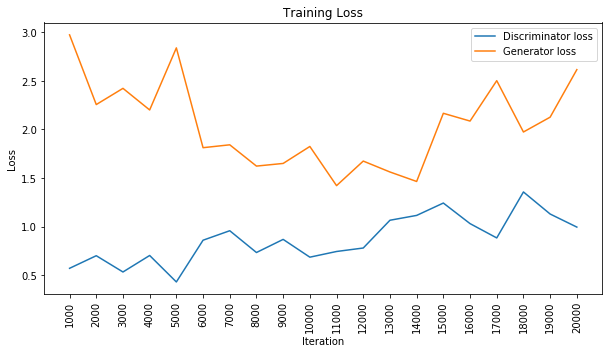

In [38]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(10, 5))
plt.plot(iteration_checkpoint, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoint, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoint, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

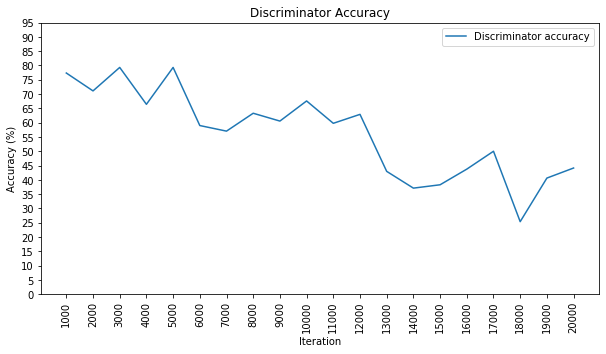

In [39]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(10, 5))
plt.plot(iteration_checkpoint, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoint, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()